Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data


In [1]:
# !pip install google-colab

### Importing all the important libraries

In [5]:
# !pip install tensorflow

import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
visions 0.7.4 requires networkx>=2.4, which is not installed.
streamlit 1.3.0 requires watchdog; platform_system != "Darwin", which is not installed.
phik 0.12.0 requires joblib>=0.14.1, which is not installed.
phik 0.12.0 requires scipy>=1.5.2, which is not installed.
pandas-profiling 3.1.0 requires joblib~=1.0.1, which is not installed.
pandas-profiling 3.1.0 requires scipy>=1.4.1, which is not installed.
pandas-profiling 3.1.0 requires seaborn>=0.10.1, which is not installed.
streamlit 1.3.0 requires click<8.0,>=7.0, but you have click 8.0.4 which is incompatible.
pandas-profiling 3.1.0 requires markupsafe~=2.0.1, but you have markupsafe 2.1.1 which is incompatible.


     --------------------------------------- 11.0/11.0 MB 12.8 MB/s eta 0:00:00


In [6]:
## If you are using the data by mounting the google drive, use the following :

# from google.colab import drive
# drive.mount('/content/gdrive')
# ##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166


## Google-Collab failing failinon the system
# loading the data from the local
train_path = 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/'
test_path = 'Skin cancer ISIC The International Skin Imaging Collaboration/Test/'
data_dir_train = pathlib.Path(train_path)
data_dir_test = pathlib.Path(test_path)

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
# data_dir_train = pathlib.Path(  + '/Train')
# data_dir_test = pathlib.Path(root_path + '/Test')


In [7]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [8]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [9]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="training",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)


Found 2739 files belonging to 9 classes.
Using 2192 files for training.


In [10]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="validation",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 2739 files belonging to 9 classes.
Using 547 files for validation.


In [11]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

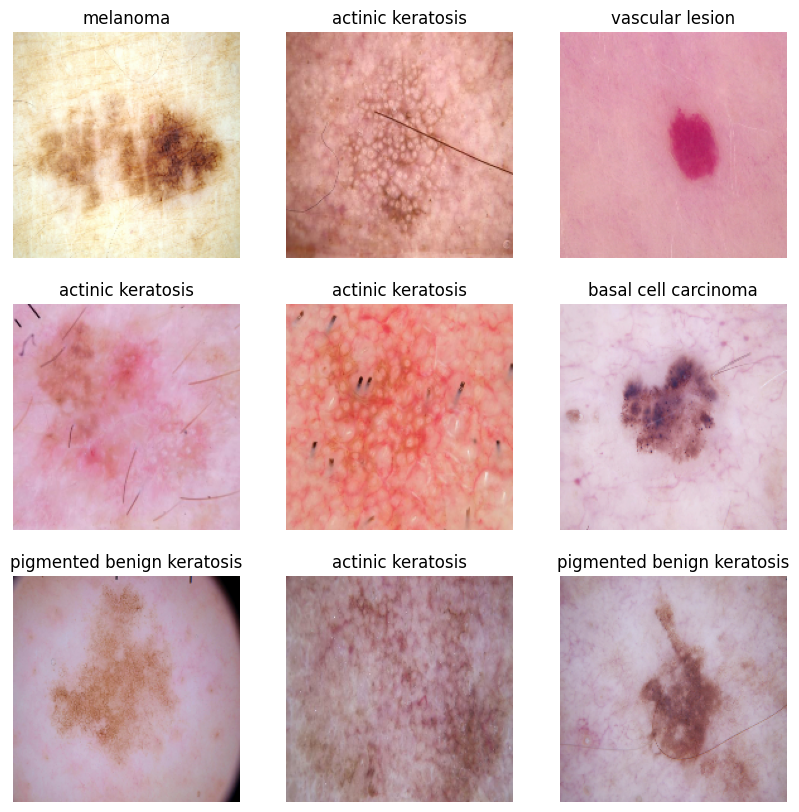

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### your code goes here, you can use training or validation data to visualize

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [14]:
#Standardize Data of RGB channel value
# normalization_layer = layers.Rescaling(1./255)
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.15000157 0.8630718


In [15]:
# getting the number of classes in the dataset
num_classes = len(class_names)

# building the model with keras Sequential with relu as activation function
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [16]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [18]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
69/69 [==============================] - 52s 744ms/step - loss: 2.0018 - accuracy: 0.2482 - val_loss: 1.7146 - val_accuracy: 0.3748
Epoch 2/20
69/69 [==============================] - 42s 603ms/step - loss: 1.5994 - accuracy: 0.4179 - val_loss: 1.4245 - val_accuracy: 0.5229
Epoch 3/20
69/69 [==============================] - 40s 578ms/step - loss: 1.4102 - accuracy: 0.4986 - val_loss: 1.3305 - val_accuracy: 0.5558
Epoch 4/20
69/69 [==============================] - 41s 589ms/step - loss: 1.3268 - accuracy: 0.5452 - val_loss: 1.3782 - val_accuracy: 0.5229
Epoch 5/20
69/69 [==============================] - 46s 675ms/step - loss: 1.2764 - accuracy: 0.5566 - val_loss: 1.2729 - val_accuracy: 0.5996
Epoch 6/20
69/69 [==============================] - 62s 893ms/step - loss: 1.1217 - accuracy: 0.6058 - val_loss: 1.3212 - val_accuracy: 0.5576
Epoch 7/20
69/69 [==============================] - 60s 874ms/step - loss: 1.0605 - accuracy: 0.6300 - val_loss: 1.3622 - val_accuracy: 0.5393

We can observe that:
Train loss = ~1.2
Train accuracy = ~0.9
Val loss = ~1.8
Val accuracy = ~.6

### Visualizing training results

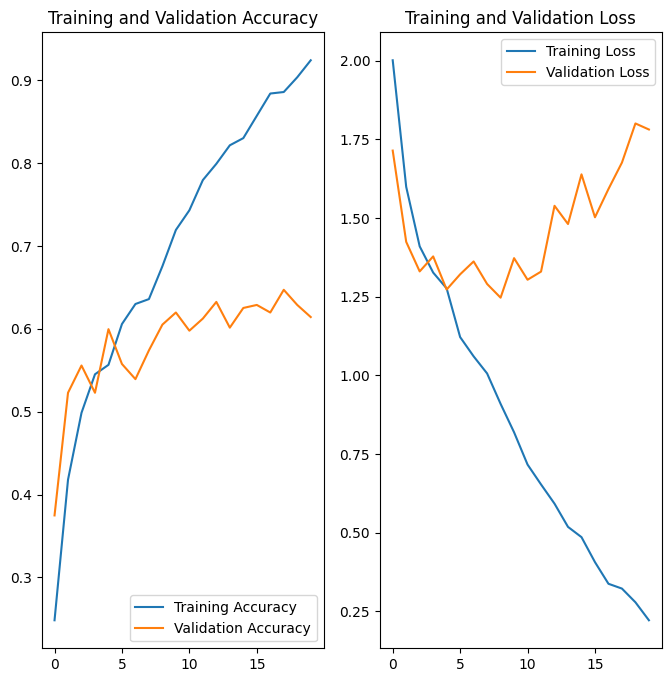

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

####  Write your findings after the model fit, see if there is an evidence of model overfit or underfit
- Validation accuracy is significantly lower as we move towards right-side of the plot
- Validation accuracy starts higher but eventually falls
- Validation Loss is very high compare to training loss towards right-side of the plot


It clearly shows signs of overfitting

### Write your findings here

In [20]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)])

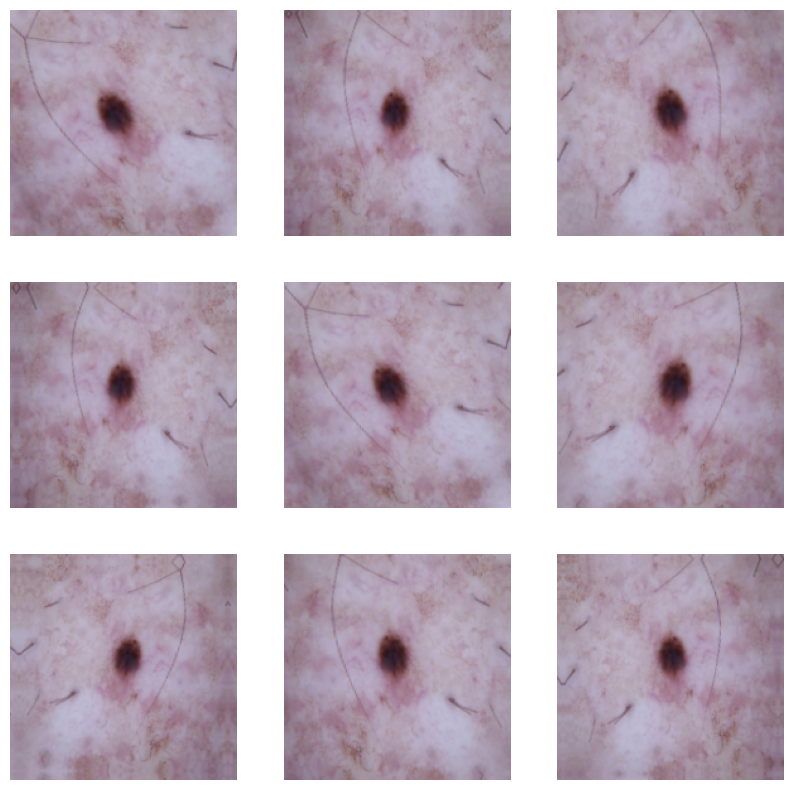

In [21]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


### Create the model, compile and train the model


In [22]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


### Compiling the model

In [23]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
# printing the model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

### Training the model

In [24]:
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
69/69 [==============================] - 46s 622ms/step - loss: 2.0494 - accuracy: 0.2281 - val_loss: 1.8118 - val_accuracy: 0.3291
Epoch 2/20
69/69 [==============================] - 44s 644ms/step - loss: 1.7713 - accuracy: 0.3463 - val_loss: 1.6764 - val_accuracy: 0.3748
Epoch 3/20
69/69 [==============================] - 51s 747ms/step - loss: 1.6061 - accuracy: 0.3992 - val_loss: 1.5720 - val_accuracy: 0.4607
Epoch 4/20
69/69 [==============================] - 50s 732ms/step - loss: 1.4978 - accuracy: 0.4653 - val_loss: 1.3895 - val_accuracy: 0.5411
Epoch 5/20
69/69 [==============================] - 48s 695ms/step - loss: 1.4026 - accuracy: 0.5164 - val_loss: 1.3441 - val_accuracy: 0.5649
Epoch 6/20
69/69 [==============================] - 44s 631ms/step - loss: 1.3368 - accuracy: 0.5388 - val_loss: 1.2864 - val_accuracy: 0.5722
Epoch 7/20
69/69 [==============================] - 46s 665ms/step - loss: 1.3089 - accuracy: 0.5411 - val_loss: 1.3041 - val_accuracy: 0.5759

### Visualizing the results

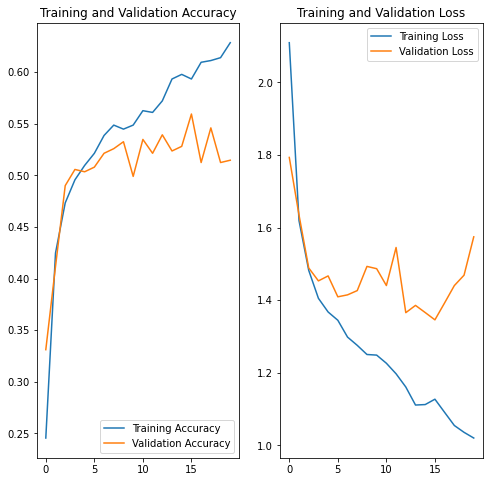

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?
- The validation and train accuracy are following similar trend.
- However , there are certain spikes in train accuracy.
- This might be a cause of class imbalance.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<Figure size 720x720 with 0 Axes>

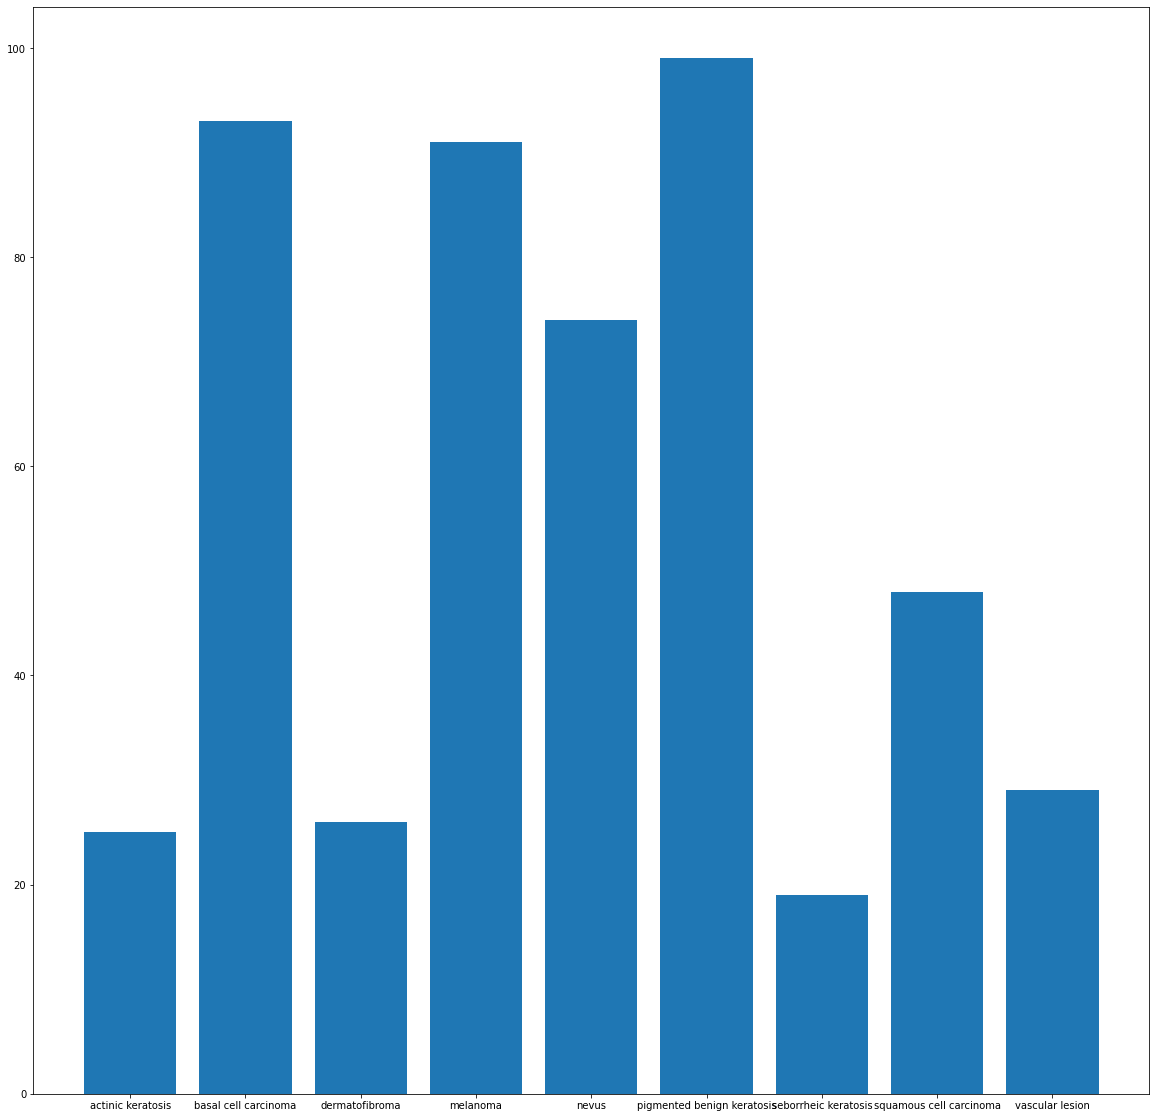

In [24]:
## Your code goes here.
# Let's check on the Class Imbalance if Present
# taking empty dictionary
class_data = dict()

# adding the empty lists for each class record in the dictionary
for i in class_names:
    class_data[i] = []

# setting the output image size
plt.figure(figsize=(10, 10))
# adding the images into the data dictionary for each class
for images, labels in train_ds:
    for i in range(9):
        class_data[class_names[labels[i]]].append(images[i].numpy().astype("uint8"))
# storing the number of images for specific class
for i in class_data:
  # getting the length and storing the dictionary
  class_data[i] = len(class_data[i]) 

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(20)
# printing the plot
plt.bar(range(len(class_data)), list(class_data.values()), align='center')
plt.xticks(range(len(class_data)), list(class_data.keys()))
plt.show()

#### **Todo:** Write your findings here: 
- We do see class imbalance here amongst different classes
#### - Which class has the least number of samples? Seborrheic keratosis 
#### - Which classes dominate the data in terms proportionate number of samples? Pigmented Benign Keratosis


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [25]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [26]:
# path_to_training_dataset="/content/gdrive/MyDrive/CNN/Skin_Data_Store/Train/"
import Augmentor
for i in class_names:
    print(i)
    p = Augmentor.Pipeline(train_path + i)
    print(train_path + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

actinic keratosis
Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis\output.Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis


Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1F76D9CD3A0>: 100%|██████████████████████████████████████████████████| 500/500 [00:04<00:00, 109.81 Samples/s]


basal cell carcinoma
Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma\output.Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma


Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1F702459A90>: 100%|███████████████████████████████████████████████████| 500/500 [00:06<00:00, 81.71 Samples/s]


dermatofibroma
Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma\output.Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma


Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1F76A5AC5E0>: 100%|███████████████████████████████████████████████████| 500/500 [00:06<00:00, 72.74 Samples/s]


melanoma
Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma\output.Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma


Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1F76D8C7100>: 100%|██████████████████████████████████████████████████| 500/500 [00:34<00:00, 14.35 Samples/s]


nevus
Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus\output.Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus


Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1F703BA9A30>: 100%|███████████████████████████████████████████████████| 500/500 [00:33<00:00, 15.01 Samples/s]


pigmented benign keratosis
Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis\output.Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis


Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1F76D8A06A0>: 100%|███████████████████████████████████████████████████| 500/500 [00:06<00:00, 74.89 Samples/s]


seborrheic keratosis
Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis\output.Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis


Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x1F703BC8280>: 100%|████████████████████████████████| 500/500 [00:16<00:00, 31.19 Samples/s]


squamous cell carcinoma
Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma\output.Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma


Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1F76A5ACA30>: 100%|███████████████████████████████████████████████████| 500/500 [00:07<00:00, 70.43 Samples/s]


vascular lesion
Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion\output.Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion


Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1F76D892820>: 100%|███████████████████████████████████████████████████| 500/500 [00:07<00:00, 63.13 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [27]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [28]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
len(path_list)

4500

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]


In [32]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [34]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [35]:
new_df['Label'].value_counts()

actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [36]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [38]:
# data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


####  Create a validation dataset

In [39]:
# creating validation dataset to check the model
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


####  Create your model (make sure to include normalization)

In [40]:
# performing autotune
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#normalizing the Data
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

# creating a model post handling the imbalancing
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

0.12998588 0.8682702


#### Compile your model (Choose optimizer and loss function appropriately)

In [41]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

####   Train your model

In [ ]:

## Your code goes here, use 50 epochs
epochs = 50

batch_size = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 170s 928ms/step - loss: 1.7824 - accuracy: 0.3155 - val_loss: 1.4424 - val_accuracy: 0.4336
Epoch 2/50
169/169 [==============================] - 149s 883ms/step - loss: 1.4543 - accuracy: 0.4505 - val_loss: 1.3247 - val_accuracy: 0.5197
Epoch 3/50
169/169 [==============================] - 149s 884ms/step - loss: 1.3355 - accuracy: 0.4941 - val_loss: 1.2125 - val_accuracy: 0.5405
Epoch 4/50
169/169 [==============================] - 151s 894ms/step - loss: 1.2295 - accuracy: 0.5399 - val_loss: 1.2125 - val_accuracy: 0.5716
Epoch 5/50
169/169 [==============================] - 166s 982ms/step - loss: 1.1563 - accuracy: 0.5710 - val_loss: 1.0571 - val_accuracy: 0.6036
Epoch 6/50
169/169 [==============================] - 345s 2s/step - loss: 1.0883 - accuracy: 0.5994 - val_loss: 1.0853 - val_accuracy: 0.5909
Epoch 7/50
169/169 [==============================] - 154s 911ms/step - loss: 1.0166 - accuracy: 0.6278 - val_loss: 1.0644 - va

####  Visualize the model results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

- The Augmentation technique has helped solve the issue of overfitting. 
- Both The validation and train accuracy follow same trend and happen to be above 70%